## accountMetrics - Measuring Site Throughput, Part 1

The **accountMetrics** query is not just a powerful API call which can be used to extract a wide variety of key performance indicators, it is also the query which powers many of the throughput graphs in CMA. It should, therefore, be possible to combine this query with a graphing library such as Matplotlib to generate graphs which are very similar to those in CMA - they should show the same data in the same timeframe with the same scaling. The peaks and troughs on the graphs we generate should match those in CMA.

Basically, we want to create this programmatically:

![goal.png](goal.png)

### Here's how to do it in Python with Matplotlib.

This first example is extremely simple - a single site with a single socket, single tunnel interface and just one metric to graph, but it will serve as a foundation from which more complex examples can be derived.

Firstly, let's import the libraries we need and set up the connection to the API. As usual, we assuming that the account ID and API key are preloaded as environment variables and we use our helper module to encapsulate the business of making an API call (see the **Getting Started** notebook if any of this is unclear):

In [37]:
#
# Initialise the API connection
#
import datetime
import json
import os
import matplotlib.pyplot as plt
from cato import API
C = API(os.environ["CATO_API_KEY"])

## The accountMetrics query

**accountMetrics** is fully documented here: [accountMetrics](https://api.catonetworks.com/documentation/#query-accountMetrics)

It is a sophisticated query with many different options, but we will be using it for the most basic operation: to fetch timeseries data for a 24 hour period with 288 buckets. Why 288? Because if you divide 24 hours into 5 minute intervals, there are 288 of them, so using this many buckets ensures that each data point on the graph represents the maximum value seen in that 5 minute window. This is an industry-standard way to measure a maximum throughput series across a 24 hour period. We could have chosen 1 hour buckets, but then we're probably losing some detail, and similarly if we had chosen more buckets (say 5 seconds rather than 5 minutes) then the graph could become extremely "spikey" and difficult to read. We might also hit an API limit on the number of returned buckets, which would require us to break our query up into multiple smaller queries.

The metric we're requesting is **bytesDownstreamMax**, which is as the name suggests, the maximum throughput in a download direction to the site.

We will also specify a site ID to ensure that we only receive data for the site in which we are interested.


In [52]:
#
# Define the query
#
query = '''
query accountMetrics($buckets:Int $accountID:ID! $timeFrame:TimeFrame! $siteIDs:[ID!]) {
	accountMetrics(accountID:$accountID timeFrame:$timeFrame groupInterfaces:false groupDevices:true) {
		sites (siteIDs:$siteIDs) {
			id
            name
			interfaces {
				name
				timeseries (labels:[bytesDownstreamMax] buckets:$buckets) {
					label
                    units
					data (perSecond:true)
				}
			}
		}
	}
}
'''


#
# Variables
#
variables = {
    "accountID": os.environ["CATO_ACCOUNT_ID"],
    "timeFrame": "utc.2025-02-11/{00:00:00--23:59:59}",
    "buckets": 288,
    "siteIDs": [119167],
}

## Sending the query

Now we send the query, and print the first 500 characters in the response. We can see that the object is highly nested, with multiple lists and dictionaries to process, but if you include the object name fields at the various levels, and pay close attention to when something is a list, you can begin to understand the layout of the response.

In [53]:
#
# Send the query
#
success, result = C.send("accountMetrics", variables, query)
print(json.dumps(result, indent=2)[:500],"...")

{
  "data": {
    "accountMetrics": {
      "sites": [
        {
          "id": "119167",
          "name": "IOT",
          "interfaces": [
            {
              "name": "WAN 01",
              "timeseries": [
                {
                  "label": "bytesDownstreamMax",
                  "units": "bytes",
                  "data": [
                    [
                      1739232000000.0,
                      26273
                    ],
                    [
                  ...


## Process the response

Each timeseries consists of a label which tells us the name of the metric provided in this timeseries, and a list of two-item lists. We don't need the label for this example, because we're only requesting a single metric; we would definitely need it if we were requesting multiple metrics.

The two-item lists are effectively tuples where the first element is the Go-style timestamp, and the second element is the value. If you ask for the **units** in the query, as we have done here, you will get back an indication of the units for this timeseries. In this case they are bytes, and with the perSecond:true in our query above, we know we're dealing with bytes per second.

The Go timestamp is in nanoseconds, so we have to divide by 1000 to convert it to a timestamp which Python can convert to a datetime object. Tp convert bytes per second to the m ore usual megabits per second, we multiply by 8 (convert to bits) and divide by 1 million (bps to Mbps).

We also create a list of custom labels for the x axis, consisting of just the hour:minute part of the timestamp.

In [54]:
#
# Construct the X and Y timeseries
#
y = []
x = []
x_labels = []
for timestamp, value in result["data"]["accountMetrics"]["sites"][0]["interfaces"][0]["timeseries"][0]["data"]:

    #
    # Convert the timestamp to a Python datetime and add to x
    #
    datetime_timestamp = datetime.datetime.fromtimestamp(timestamp/1000)
    x.append(datetime_timestamp)

    #
    # Convert the value to megabits per second and add to x
    #
    bps = value*8/1_000_000
    y.append(bps)

    #
    # Custom x-axis labels
    #
    x_label = datetime_timestamp.strftime("%H:%M")
    x_labels.append(x_label)

## Create the graph

Now that we have processed the response into suitably-scaled and converted x and y arrays, plotting them with Matplotlib is fairly straightforward.

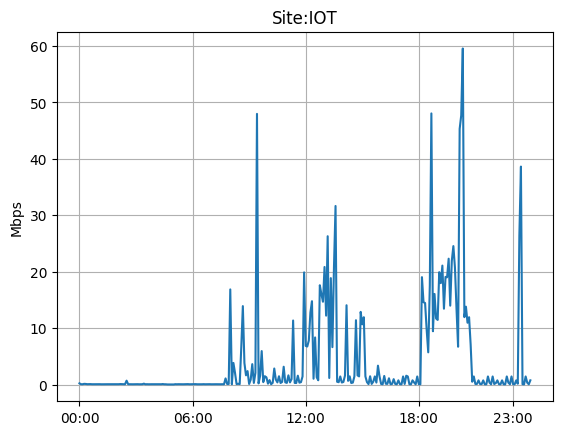

In [55]:
#
# We only want several specific X-labels
#
xtick_locs = []
xtick_labels = []
for i,label in zip(x, x_labels):
    if label in ["00:00", "06:00", "12:00", "18:00", "23:00"]:
        xtick_locs.append(i)
        xtick_labels.append(label)

#
# Create and show the graph
#
plt.close("all")
plt.title(f"Site:{result["data"]["accountMetrics"]["sites"][0]["name"]}")
plt.ylabel(f"Mbps")
plt.xticks(xtick_locs, xtick_labels)
plt.grid()
plt.plot(x, y)
plt.show()


That graph is clearly showing the same data as the example from CMA:

![goal.png](goal.png)